*Authors:* Ismael Mendoza, Andrii Torchylo

*Outline*

- How to use each deblender and example detections or reconstructions (plots)

- At least one example of customizing the hyper-parameters of a given deblender and how that changes output

- How to run multiple deblenders simultaneously on the same data (sep + peak_finder)

In [1]:
import btk
from btk.deblend import DeblendGenerator
from btk.deblend import PeakLocalMax, SepSingleBand, SepMultiband, Scarlet

In [2]:
catalog_name = "../data/input_catalog.fits" # contains ~85k entries
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
LSST = btk.survey.get_surveys("LSST")

In [3]:
# fix parameters of the generation
SEED = 1
max_n_sources = 10

# construct a sampling function 
sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_n_sources,
    min_number=1,
    stamp_size=24.0,
    max_shift=3.0,
    min_mag = 24, 
    max_mag = 25,
    seed=SEED,
)

# creates a generator object to draw galaxies
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=5,
    stamp_size=24.0,
    njobs=1,
    add_noise="all",
    seed=SEED,
)

# get an example batch
blend_batch = next(draw_generator)
print(blend_batch)

BlendBatch(survey_name=LSST, 
	 blend_images: np.ndarray, shape [5, 6, 120, 120]
	 isolated_images: np.ndarray, shape [5, 10, 6, 120, 120]
	 catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	 psfs: list of <class 'galsim.gsobject.GSObject'>, size 6
	 wcs: <class 'astropy.wcs.wcs.WCS'>)


## Internal Structure of the deblenders

TODO: Edit description -- maybe say more about each method/make description more readable

All implemented deblenders follow the same template — abstract Deblender class. Basically, deblender class standardizes inputs and outputs of the deblender. The `__init__` class has a required argument — `max_n_sources`, which is needed to set a fixed shape for the output of the deblender. All deblenders must implement `__deblend__` method, which performs deblending on the i-th example from the `BlendBatch`. The `__call__` and `batch_call` are internally implemented in the parent class, and user doesn't need to modify them to create a deblender. These two methods implement multiprocessing procedure to efficiently paralelize computation across several CPU cores. Finally `__repr__` class is used for internall bookkeeping.  

```python
class Deblender(ABC):
    """Abstract base class containing the measure class for BTK. """

    def __init__(self, max_n_sources: int) -> None:
        """Initialize the Deblender class. """
        # (Optionally) overwritten in the child class
    
    @abstractmethod
    def deblend(self, ii: int, blend_batch: BlendBatch) -> DeblendExample:
        """Runs the deblender on the ii-th example of a given batch."""
        # Must be overritten in the child class

    def __call__(self, blend_batch: BlendBatch, njobs: int = 1, **kwargs) -> DeblendBatch:
        """Calls the (user-implemented) `deblend` method along with validation of the input."""

    def batch_call(self, blend_batch: BlendBatch, njobs: int = 1, **kwargs) -> DeblendBatch:
        """Implements multiprocessing call of a measure function on the entire batch."""
    
    @classmethod
    def __repr__(cls):
        """Returns the name of the class for bookkeeping."""
        return cls.__name__
```

## Creating Your Own Deblender

Let's walk through teh process of creating your own Deblender. We will use `PeakLocalMax` which BTK implements as an example. To start of we need to create a subclass of the `Deblender` class:

```python
class PeakLocalMax(Deblender):
    """This class detects centroids with `skimage.feature.peak_local_max`."""
```
As the comment suggests we will be using a function `skimage.feature.peak_local_max` to perform galaxy detection. By default, this fucniton works on a grayscale image, but in the blend batch we have access to multiple filter. Thus, we will let the user either use a particular filter by specifiyng the index of the band (i.e. `use_band=3`) or average across the filters if `use_mean=True` is turned on. Additionally, we save the parameters such as `sky_level`, `threshold_scale`, and `min_distance` to filter out noisy detections.  Here are the details of the `__init__` class:

```python
def __init__(
    self,
    max_n_sources: int,
    sky_level: float,
    threshold_scale: int = 5,
    min_distance: int = 2,
    use_mean: bool = False,
    use_band: Optional[int] = None,
) -> None:
    """Initializes Deblender class. Exactly one of 'use_mean' or 'use_band' must be specified.

    Args:
        max_n_sources: See parent class.
        sky_level: Background intensity in images to be detected (assumed constant).
        threshold_scale: Minimum number of sigmas above noise level for detections.
        min_distance: Minimum distance in pixels between two peaks.
        use_mean: Flag to use the band average for deblending.
        use_band: Integer index of the band to use for deblending
    """
    super().__init__(max_n_sources)
    self.min_distance = min_distance
    self.threshold_scale = threshold_scale
    self.sky_level = sky_level

    if use_band is None and not use_mean:
        raise ValueError("Either set 'use_mean=True' OR indicate a 'use_band' index")
    if use_band is not None and use_mean:
        raise ValueError("Only one of the parameters 'use_band' and 'use_mean' has to be set")
    self.use_mean = use_mean
    self.use_band = use_band
```

Now comes the crucial step —- implementing `deblend` method.  The first step of any `deblend` method is to index into the `BlendBatch` and slect the data that corresponds to the i-th example. In this case, we just need the `blend_image`. Once we selected the target grayscale image (either by averaging or by fixing a band) we run `peak_local_max` on the image. Notice that the output coordinates will be in the pixel values, but the requirement for the BTK is to convert output coordinates to `ra` and `dec`, and wrap the detection in `atropy.Table`. Finally we package the output into an object called `DeblendExample` that conevniently stores our data. 

```python
def deblend(self, ii: int, blend_batch: BlendBatch) -> DeblendExample:
    """Performs deblending on the ii-th example from the batch."""
    blend_image = blend_batch.blend_images[ii]
    image = np.mean(blend_image, axis=0) if self.use_mean else blend_image[self.use_band]

    # compute threshold value
    threshold = self.threshold_scale * np.sqrt(self.sky_level)

    # calculate coordinates
    coordinates = peak_local_max(
        image,
        min_distance=self.min_distance,
        threshold_abs=threshold,
        num_peaks=self.max_n_sources,
    )
    x, y = coordinates[:, 1], coordinates[:, 0]

    # convert coordinates to ra, dec
    wcs = blend_batch.wcs
    ra, dec = wcs.pixel_to_world_values(x, y)
    ra *= 3600
    dec *= 3600

    # wrap in catalog
    catalog = Table()
    catalog["ra"], catalog["dec"] = ra, dec
    catalog["x_peak"], catalog["y_peak"] = x, y

    if len(catalog) > self.max_n_sources:
        raise ValueError(
            "`PeakLocalMax` detected more sources than `max_n_sources`. Consider increasing"
            "`threshold_scale` or `max_n_sources`."
        )

    return DeblendExample(self.max_n_sources, catalog)
```

## Running Deblenders
Let's test the output of the `PeakLocalMax` on an example batch

In [21]:
PLM = PeakLocalMax(max_n_sources, use_mean=True) # use_band=2)
deblend_example = PLM.deblend(3, blend_batch) # 3rd example from the batch
print(deblend_example)


DeblendExample(max_n_sources = 10, n_bands = None, image_size = None), 
 containing: 
	catalog: <class 'astropy.table.table.Table'>
	segmentation: None
	deblended_images: None


Segmentation, and deblended images are None because our deblenders only does the detection. Let's look at the detected coordiantes. Technically, we require only `ra` and `dec` to be saved, but saving `x_peak` and `y_peak` can be useful for visualization purposes.

In [22]:
print(deblend_example.catalog)

        ra                 dec         x_peak y_peak
------------------ ------------------- ------ ------
         1295999.9  0.4999999999935611     59     62
0.2999999999910497  1.8999999999015411     61     69
         1295997.3 -1.2999999998874094     46     53


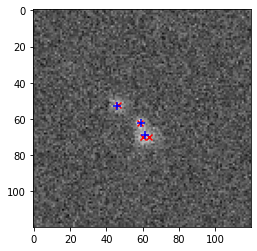

In [23]:
import matplotlib.pyplot as plt

# plot the first blend in the batch, with the r-band
plt.imshow(blend_batch.blend_images[3, 2, :, :], cmap="gray")

# plot centers of truth
plt.scatter(blend_batch.catalog_list[3]["x_peak"], blend_batch.catalog_list[3]["y_peak"], c="r", marker="x")

# plot centers of prediction
x, y = deblend_example.catalog['x_peak'], deblend_example.catalog['y_peak']
plt.scatter(x, y, c="b", marker="+", s=50)

Now suppose we want to efficeintly run our deblender on the entire batch. We can do so efficiently by calling the following command:

In [24]:
deblend_batch = PLM(blend_batch, njobs=1) # deblend the whole batch
print(deblend_batch)

DeblendBatch(batch_size = 5, max_n_sources = 10 n_bands = None, image_size = 120), containing: 
	catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	segmentation: None
	deblended_images: None


Finally if we want to collect more statistics about the performace of our deblender, we can run our deblender on many batches using `DeblendGenerator`

TODO visualize multiple batches? Not sure what to do with the list of deblend batches

In [35]:
deblend_generator = DeblendGenerator(PLM, draw_generator, njobs=1)
deblend_batches = []
for i in range(5): # run on 5 batches
    blend_batch, deblend_batch = next(deblend_generator)
    deblend_batches.append(deblend_batch)

## Segmentation and Deblending 

TODO explain required outputs for segmentation and deblending

In [31]:
SEP = SepSingleBand(max_n_sources, use_mean=True) # use_band=2)
deblend_example = SEP.deblend(3, blend_batch) # 3rd example from the batch
print(deblend_example)

DeblendExample(max_n_sources = 10, n_bands = 1, image_size = 120), 
 containing: 
	catalog: <class 'astropy.table.table.Table'>
	segmentation: <class 'numpy.ndarray'>, shape [10, 120, 120]
	deblended_images: <class 'numpy.ndarray'>, shape [10, 1, 120, 120]


TODO also visualize segmentation/deblended images

## Running multiple deblenders 

In [32]:
PLM = PeakLocalMax(max_n_sources, use_mean=True) # use_band=2)
SEP = SepSingleBand(max_n_sources, use_mean=True) # use_band=2)
SEPMulti = SepMultiband(max_n_sources)
SCARLET = Scarlet(max_n_sources)

deblenders = [PLM, SEP, SEPMulti, SCARLET]

In [37]:
deblend_generator = DeblendGenerator(deblenders, draw_generator, njobs=4)
blend_batch, deblend_batch = next(deblend_generator)
print(deblend_batch)

{'PeakLocalMax': DeblendBatch(batch_size = 5, max_n_sources = 10 n_bands = None, image_size = 120), containing: 
	catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	segmentation: None
	deblended_images: None, 'SepSingleBand': DeblendBatch(batch_size = 5, max_n_sources = 10 n_bands = 1, image_size = 120), containing: 
	catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	segmentation: <class 'numpy.ndarray'>, shape [5, 10, 120, 120]
	deblended_images: <class 'numpy.ndarray'>, shape [5, 10, 1, 120, 120], 'SepMultiband': DeblendBatch(batch_size = 5, max_n_sources = 10 n_bands = None, image_size = 120), containing: 
	catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	segmentation: None
	deblended_images: None, 'Scarlet': DeblendBatch(batch_size = 5, max_n_sources = 10 n_bands = 6, image_size = 120), containing: 
	catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	segmentation: None
	deblended_images: <class 'numpy.ndarray'>, sha